In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pymannkendall as mk


In [3]:
P_data1 = pd.read_csv('data/total_precipitation/precip_2000_2011.csv')
P_data2 = pd.read_csv('data/total_precipitation/precip_2012_2023.csv')
P_data = pd.concat([P_data1, P_data2])
P_data['date'] = pd.to_datetime(P_data['date'])
P_data['year'] = P_data['date'].dt.year
P_data.head()

,date,lat,lon,tp,year
0,2000-01-01,55.25,4.75,0.003465,2000
1,2000-01-01,55.25,5.25,0.003525,2000
2,2000-01-01,55.25,5.75,0.003562,2000
3,2000-01-01,55.25,6.25,0.003803,2000
4,2000-01-01,55.25,6.75,0.004075,2000


In [8]:
P_data['lon'].unique()

array([ 4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
        9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
       13.75, 14.25, 14.75, 15.25])

In [6]:
P_data['lat'].unique()

array([55.25, 54.75, 54.25, 53.75, 53.25, 52.75, 52.25, 51.75, 51.25,
       50.75, 50.25, 49.75, 49.25, 48.75, 48.25, 47.75, 47.25, 46.75,
       46.25, 45.75, 45.25, 44.75])

In [6]:
lat = 53.25
lon = 10.25
P_sample = P_data[(P_data['lon'] == lon) & (P_data['lat'] == lat)]
P_sample['date'] = pd.to_datetime(P_sample['date'])
P_sample.set_index('date', inplace=True)
P_sample['rolling_std_month'] = P_sample['tp'].rolling(window=30).std()
P_sample['rolling_std_year'] = P_sample['tp'].rolling(window=365).std()

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_14268\475892272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_sample['date'] = pd.to_datetime(P_sample['date'])
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_14268\475892272.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_sample['rolling_std_month'] = P_sample['tp'].rolling(window=30).std()
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_14268\475892272.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

### Sample with rollig std

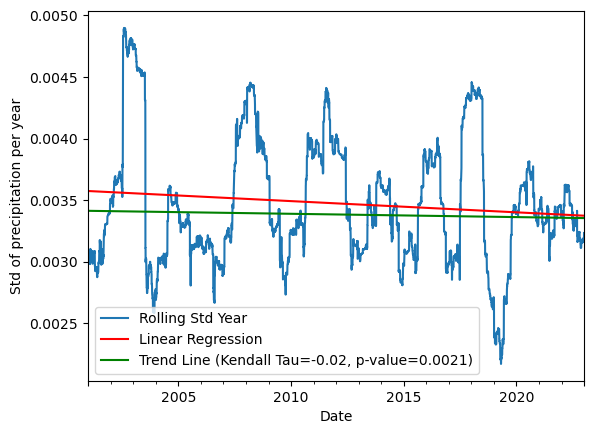

In [18]:
P_sample_clean = P_sample.dropna(subset=['rolling_std_year'])

# Fit a linear regression line
x = np.array(range(len(P_sample_clean.index)))
y = P_sample_clean['rolling_std_year'].values
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
mk_result = mk.original_test(y)

# Plot the data and the regression line
P_sample_clean['rolling_std_year'].plot(label='Rolling Std Year')
plt.plot(P_sample_clean.index, polynomial(x), color='red', label='Linear Regression')
plt.plot(P_sample_clean.index, mk_result.slope * x + mk_result.intercept, color='green', label=f'Trend Line (Kendall Tau={mk_result.Tau:.2f}, p-value={mk_result.p:.4f})')
plt.xlabel('Date')
plt.ylabel('Std of precipitation per year')
plt.legend()
plt.show()

### Sample with yearly std

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_14268\1173862553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_sample['year'] = P_sample.index.year


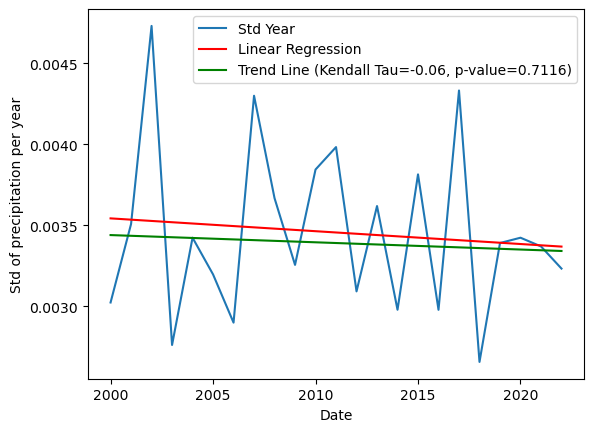

In [25]:
P_sample['year'] = P_sample.index.year
yearly_std = P_sample.groupby('year')['tp'].std()

# Fit a linear regression line
x = np.array(range(len(yearly_std.index)))
y = yearly_std.values
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
mk_result = mk.original_test(y)

# Plot the data and the regression line
yearly_std.plot(label='Std Year')
plt.plot(yearly_std.index, polynomial(x), color='red', label='Linear Regression')
plt.plot(yearly_std.index, mk_result.slope * x + mk_result.intercept, color='green', label=f'Trend Line (Kendall Tau={mk_result.Tau:.2f}, p-value={mk_result.p:.4f})')
plt.xlabel('Date')
plt.ylabel('Std of precipitation per year')
plt.legend()
plt.show()

### Sample with rolling std (monthly)

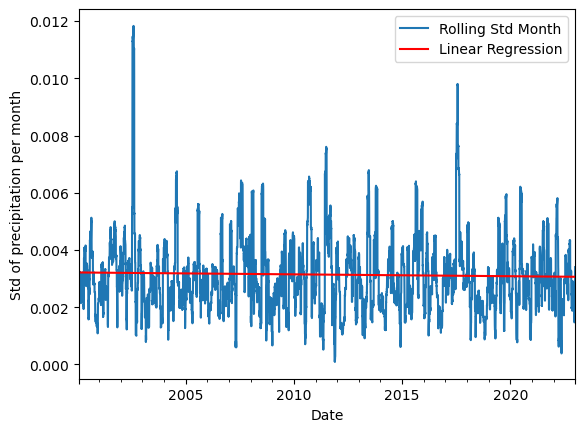

In [96]:
P_sample_clean = P_sample.dropna(subset=['rolling_std_month'])

# Fit a linear regression line
x = np.array(range(len(P_sample_clean.index)))
y = P_sample_clean['rolling_std_month'].values
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Plot the data and the regression line
P_sample_clean['rolling_std_month'].plot(label='Rolling Std Month')
plt.plot(P_sample_clean.index, polynomial(x), color='red', label='Linear Regression')
plt.xlabel('Date')
plt.ylabel('Std of precipitation per month')
plt.legend()
plt.show()

### Linear Regression for all grid cells

In [132]:
trends_df = {
    'lat': [],
    'lon': [],
    'trend_coef': [],
    'trend_p_value': [] 
}

for (lat, lon), P_sample in P_data.groupby(['lat', 'lon']):
    P_sample['rolling_std_year'] = P_sample['tp'].rolling(window=365).std()

    # Fit a linear model
    P_sample = P_sample.dropna(subset=['rolling_std_year'])
    x = np.array(range(len(P_sample.index)))
    X = sm.add_constant(x)
    y = P_sample['rolling_std_year'].values
    model = sm.OLS(y, X).fit()

    trends_df['lat'].append(lat)
    trends_df['lon'].append(lon)
    trends_df['trend_coef'].append(model.params[1])
    trends_df['trend_p_value'].append(model.pvalues[1])


In [133]:
# Iteriere über die Werte im Dictionary
for key, value in trends_df.items():
    # Überprüfe, ob der Schlüssel 'trend_p_value' ist und ob der Wert größer als 0.05 ist
    if key == 'trend_p_value':
        for i, val in enumerate(value):
            if val > 0.05:
                # Setze NA-Wert in 'trend_coefficient' ein
                trends_df['trend_coef'][i] = np.nan


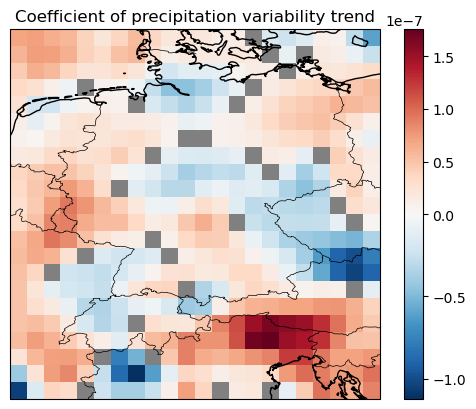

In [139]:
# Create a DataArray with latitude, longitude, and the value
data_array = xr.DataArray(np.reshape(list(trends_df['trend_coef']),(len(np.unique(trends_df['lon'])), len(np.unique(trends_df['lat'])))),
                          coords={'lat': np.unique(trends_df['lat']), 'lon': np.unique(trends_df['lon'])},
                          dims=['lat', 'lon'])

# Create a figure and a set of subplots
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.coastlines()

# Define color map
cmap = plt.cm.RdBu_r
cmap.set_bad(color='gray')

# Plot the data
norm = TwoSlopeNorm(vmin=data_array.min(), vcenter=0, vmax=data_array.max())
data_array.plot.imshow(x='lon', y='lat', norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), ax=ax)

plt.title('Coefficient of precipitation variability trend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

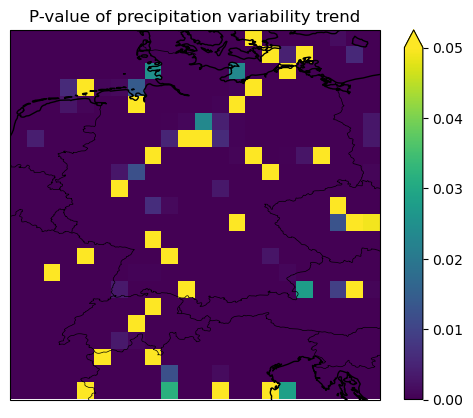

In [125]:
# Create a DataArray with latitude, longitude, and the value
data_array = xr.DataArray(np.reshape(list(trends_df['trend_p_value']),(len(np.unique(trends_df['lon'])), len(np.unique(trends_df['lat'])))),
                          coords={'lat': np.unique(trends_df['lat']), 'lon': np.unique(trends_df['lon'])},
                          dims=['lat', 'lon'])

# Create a figure and a set of subplots
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.coastlines()


# Plot the data
data_array.plot.imshow(x='lon', y='lat', cmap='viridis', transform=ccrs.PlateCarree(), ax=ax, vmax=0.05)

plt.title('P-value of precipitation variability trend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### MK test for all grid cells

In [4]:
trends_df = {
    'lat': [],
    'lon': [],
    'trend': [],
    'h': [],
    'p': [],
    'z': [],
    'Tau': [],
    's': [],
    'var_s': [],
    'slope': [],
    'intercept': [],
    'trend_coef': [],
    'trend_p_value': []
}

for (lat, lon), P_sample in P_data.groupby(['lat', 'lon']):
    # Resample data on a yearly basis and calculate standard deviation
    yearly_std = P_sample.groupby('year')['tp'].std()

    # Fit a linear model
    x = np.array(range(len(yearly_std.index)))
    X = sm.add_constant(x)
    y = yearly_std.values
    model = sm.OLS(y, X).fit()

    # Run Mann-Kendall test
    result = mk.original_test(y)

    trends_df['lat'].append(lat)
    trends_df['lon'].append(lon)
    trends_df['trend'].append(result.trend)
    trends_df['h'].append(result.h)
    trends_df['p'].append(result.p)
    trends_df['z'].append(result.z)
    trends_df['Tau'].append(result.Tau)
    trends_df['s'].append(result.s)
    trends_df['var_s'].append(result.var_s)
    trends_df['slope'].append(result.slope)
    trends_df['intercept'].append(result.intercept)
    trends_df['trend_coef'].append(model.params[1])
    trends_df['trend_p_value'].append(model.pvalues[1])

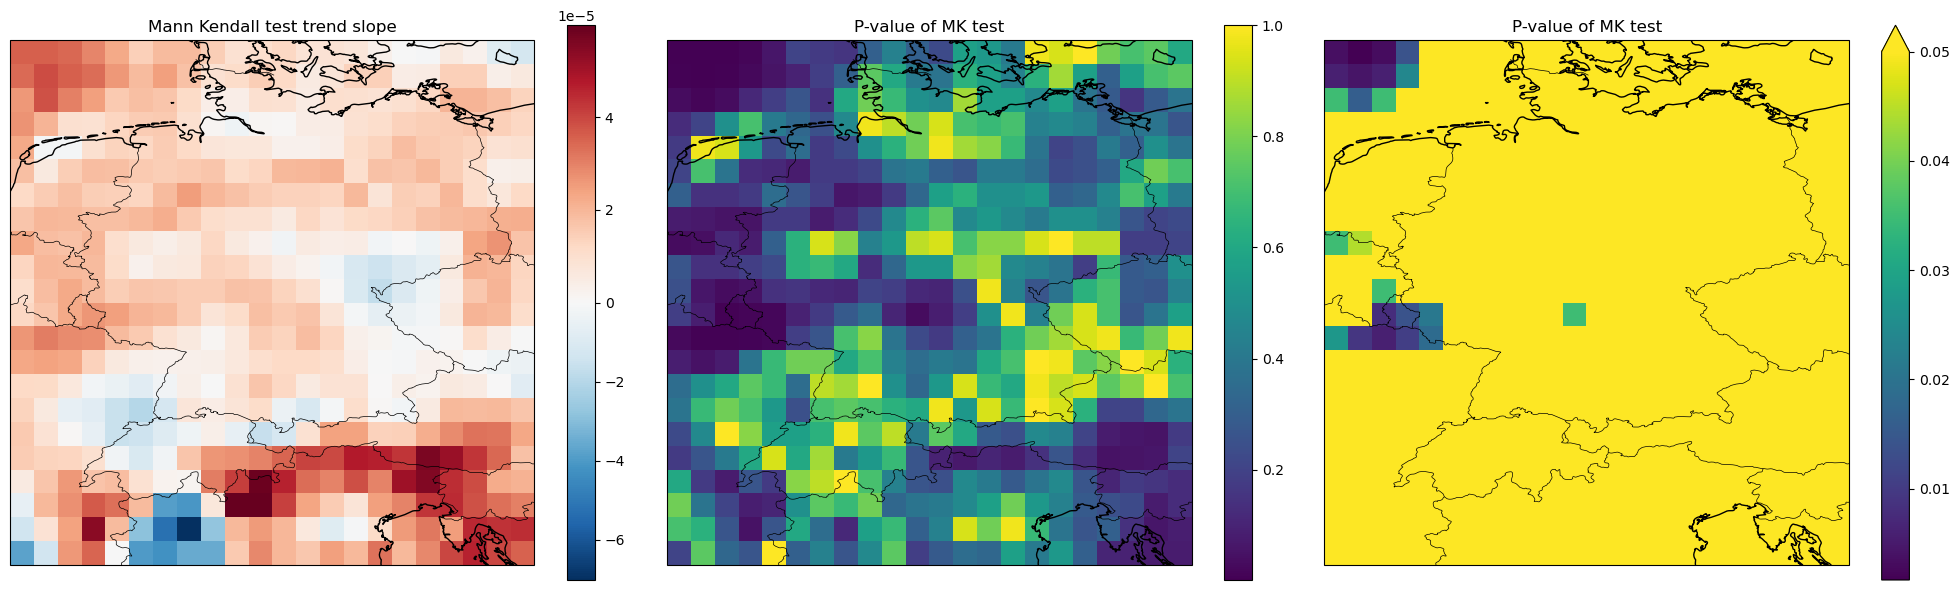

In [5]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 6))

# Define color map for slope
cmap_slope = plt.cm.RdBu_r
cmap_slope.set_bad(color='gray')

# Plot slope data
data_array_slope = xr.DataArray(np.reshape(list(trends_df['slope']),(len(np.unique(trends_df['lon'])), len(np.unique(trends_df['lat'])))),
                          coords={'lat': np.unique(trends_df['lat']), 'lon': np.unique(trends_df['lon'])},
                          dims=['lat', 'lon'])
norm_slope = TwoSlopeNorm(vmin=data_array_slope.min(), vcenter=0, vmax=data_array_slope.max())
data_array_slope.plot.imshow(x='lon', y='lat', norm=norm_slope, cmap=cmap_slope, transform=ccrs.PlateCarree(), ax=axs[0])
axs[0].set_title('Mann Kendall test trend slope')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)
axs[0].coastlines()

# Define color map for p-value
cmap_p = plt.cm.viridis

# Plot p-value data
data_array_p = xr.DataArray(np.reshape(list(trends_df['p']),(len(np.unique(trends_df['lon'])), len(np.unique(trends_df['lat'])))),
                          coords={'lat': np.unique(trends_df['lat']), 'lon': np.unique(trends_df['lon'])},
                          dims=['lat', 'lon'])
data_array_p.plot.imshow(x='lon', y='lat', cmap=cmap_p, transform=ccrs.PlateCarree(), ax=axs[1])
axs[1].set_title('P-value of MK test')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].add_feature(cfeature.BORDERS, linewidth=0.5)
axs[1].coastlines()

data_array_p.plot.imshow(x='lon', y='lat', cmap=cmap_p, transform=ccrs.PlateCarree(), ax=axs[2], vmax=0.05)
axs[2].set_title('P-value of MK test')
axs[2].set_xlabel('Longitude')
axs[2].set_ylabel('Latitude')
axs[2].add_feature(cfeature.BORDERS, linewidth=0.5)
axs[2].coastlines()

plt.tight_layout()
plt.savefig('figs/mann_kendall_map.png', dpi=300)
plt.show()

### Plot Max and Min Trend

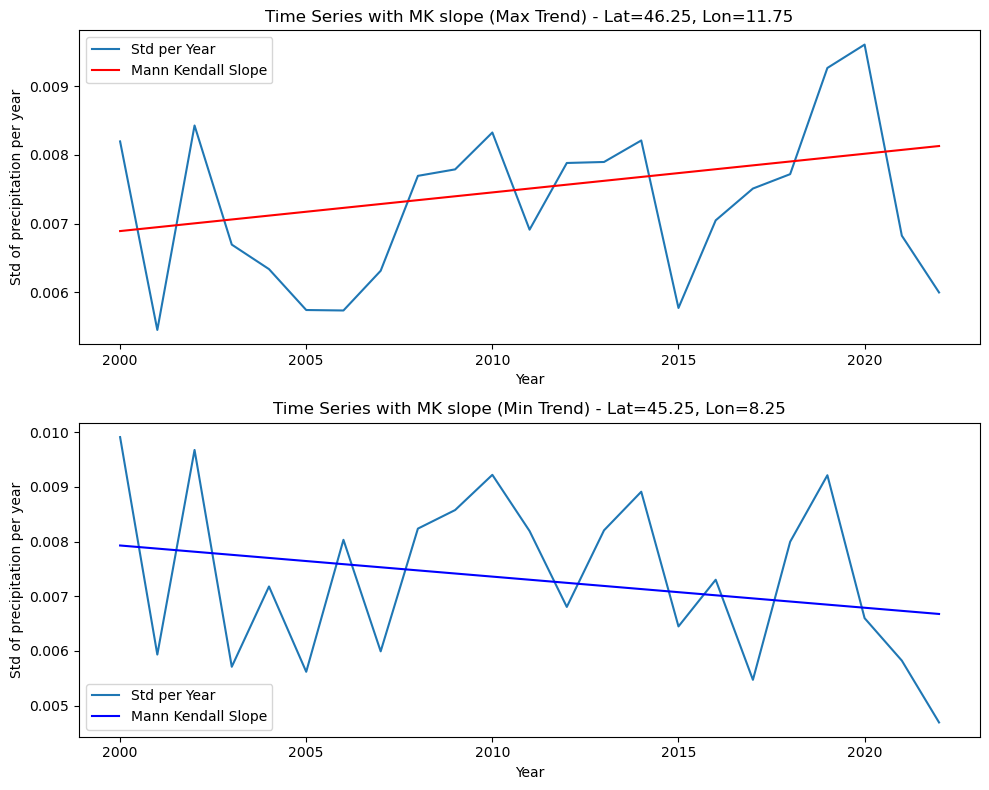

In [70]:
yearly_std_lat_lon = P_data.groupby(['lat', 'lon', 'year'])['tp'].std()
yearly_std_lat_lon = pd.DataFrame(yearly_std_lat_lon)


trends_pdf = pd.DataFrame(trends_df)
# Get the index of the maximum and minimum trend_coef values
max_idx = trends_pdf['slope'].idxmax()
min_idx = trends_pdf['slope'].idxmin()

# Extract latitude and longitude for maximum and minimum trend_coef
lat_max = trends_pdf.loc[max_idx, 'lat']
lon_max = trends_pdf.loc[max_idx, 'lon']
lat_min = trends_pdf.loc[min_idx, 'lat']
lon_min = trends_pdf.loc[min_idx, 'lon']
slope_max = trends_pdf.loc[max_idx, 'slope']
slope_min = trends_pdf.loc[min_idx, 'slope']
intercept_max = trends_pdf.loc[max_idx, 'intercept']
intercept_min = trends_pdf.loc[min_idx, 'intercept']

max_trend_data = yearly_std_lat_lon.loc[(lat_max, lon_max)]
min_trend_data = yearly_std_lat_lon.loc[(lat_min, lon_min)]

x = np.array(range(len(min_trend_data.index)))

# Plot the time series with regression line for both max and min trends
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot for max trend
axes[0].plot(max_trend_data.index, max_trend_data['tp'], label='Std per Year')
axes[0].plot(max_trend_data.index, x*slope_max+intercept_max, color='red', label='Mann Kendall Slope')
axes[0].set_title(f'Time Series with MK slope (Max Trend) - Lat={lat_max}, Lon={lon_max}')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Std of precipitation per year')
axes[0].legend()

# Plot for min trend
axes[1].plot(min_trend_data.index, min_trend_data['tp'], label='Std per Year')
axes[1].plot(min_trend_data.index, x*slope_min+intercept_min, color='blue', label='Mann Kendall Slope')
axes[1].set_title(f'Time Series with MK slope (Min Trend) - Lat={lat_min}, Lon={lon_min}')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Std of precipitation per year')
axes[1].legend()

plt.tight_layout()
plt.savefig('figs/mann_kendall_time_series_max_min.png', dpi=300)
plt.show()


/Users/johanna/Uni/applied_land_surface_modelling/env/lib/python3.11/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/Users/johanna/Uni/applied_land_surface_modelling/env/lib/python3.11/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/var/folders/f8/v13bbmv53_z7q9w1_d8cgy780000gn/T/ipykernel_47041/2316632502.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

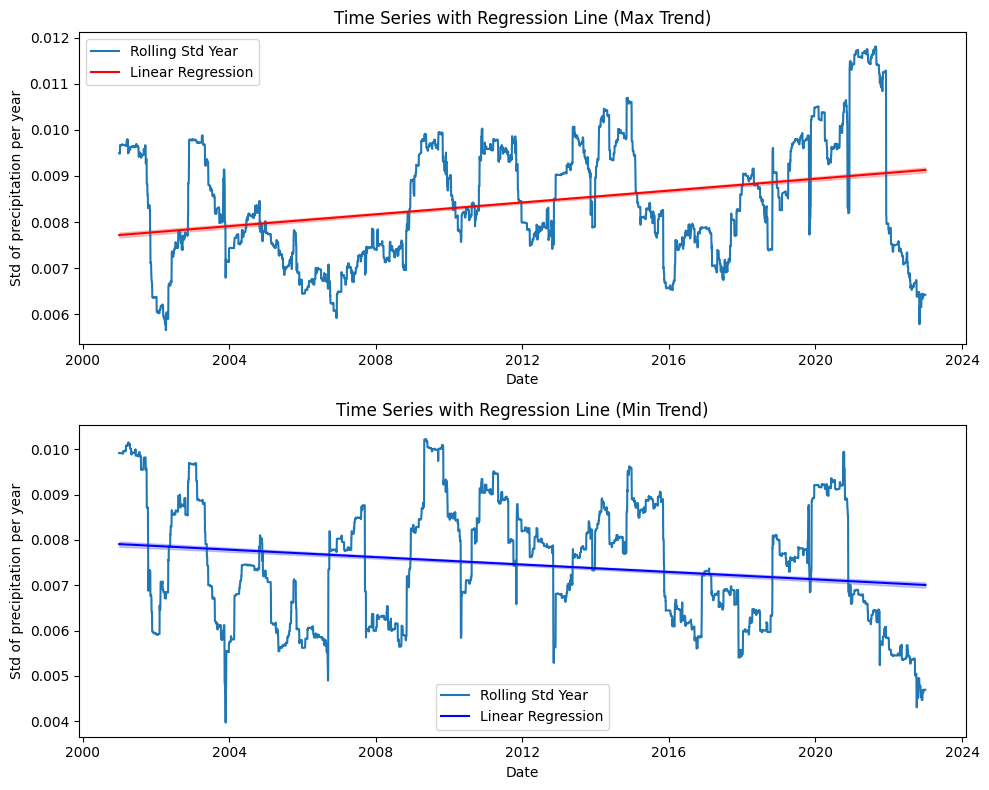

In [46]:
trends_pdf = pd.DataFrame(trends_df)
# Get the index of the maximum and minimum trend_coef values
max_idx = trends_pdf['trend_coef'].idxmax()
min_idx = trends_pdf['trend_coef'].idxmin()

# Extract latitude and longitude for maximum and minimum trend_coef
lat_max = trends_pdf.loc[max_idx, 'lat']
lon_max = trends_pdf.loc[max_idx, 'lon']
lat_min = trends_pdf.loc[min_idx, 'lat']
lon_min = trends_pdf.loc[min_idx, 'lon']

max_trend_data = P_data[(P_data['lat'] == lat_max) & (P_data['lon'] == lon_max)]
min_trend_data = P_data[(P_data['lat'] == lat_min) & (P_data['lon'] == lon_min)]

max_trend_data.loc[:, 'date'] = pd.to_datetime(max_trend_data['date'])
max_trend_data.set_index('date', inplace=True)

min_trend_data.loc[:, 'date'] = pd.to_datetime(min_trend_data['date'])
min_trend_data.set_index('date', inplace=True)

max_trend_data.loc[:, 'rolling_std_year'] = max_trend_data['tp'].rolling(window=365).std()
min_trend_data.loc[:, 'rolling_std_year'] = min_trend_data['tp'].rolling(window=365).std()

# Fit a linear model for max_trend_data
max_trend_data = max_trend_data.dropna(subset=['rolling_std_year'])
x_max = np.array(range(len(max_trend_data.index)))
X_max = sm.add_constant(x_max)
y_max = max_trend_data['rolling_std_year'].values
model_max_trend = sm.OLS(y_max, X_max).fit()

# Fit a linear model for min_trend_data
min_trend_data = min_trend_data.dropna(subset=['rolling_std_year'])
x_min = np.array(range(len(min_trend_data.index)))
X_min = sm.add_constant(x_min)
y_min = min_trend_data['rolling_std_year'].values
model_min_trend = sm.OLS(y_min, X_min).fit()

# Plot the time series with regression line for both max and min trends
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot for max trend
axes[0].plot(max_trend_data.index, max_trend_data['rolling_std_year'], label='Rolling Std Year')
axes[0].plot(max_trend_data.index, model_max_trend.predict(X_max), color='red', label='Linear Regression')
axes[0].fill_between(max_trend_data.index, 
                     model_max_trend.get_prediction(X_max).conf_int()[:, 0], 
                     model_max_trend.get_prediction(X_max).conf_int()[:, 1], color='red', alpha=0.2)
axes[0].set_title('Time Series with Regression Line (Max Trend)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Std of precipitation per year')
axes[0].legend()

# Plot for min trend
axes[1].plot(min_trend_data.index, min_trend_data['rolling_std_year'], label='Rolling Std Year')
axes[1].plot(min_trend_data.index, model_min_trend.predict(X_min), color='blue', label='Linear Regression')
axes[1].fill_between(min_trend_data.index, 
                     model_min_trend.get_prediction(X_min).conf_int()[:, 0], 
                     model_min_trend.get_prediction(X_min).conf_int()[:, 1], color='blue', alpha=0.2)
axes[1].set_title('Time Series with Regression Line (Min Trend)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Std of precipitation per year')
axes[1].legend()

plt.tight_layout()
plt.show()

### MK Test per season

In [12]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import mannwhitneyu

# Ein DataFrame zum Speichern der Trends pro Jahreszeit erstellen
trends_df = {
    'lat': [],
    'lon': [],
    'season': [],
    'trend': [],
    'h': [],
    'p': [],
    'z': [],
    'Tau': [],
    's': [],
    'var_s': [],
    'slope': [],
    'intercept': [],
    'trend_coef': [],
    'trend_p_value': []
}

# Jahreszeiten definieren
seasons = {
    'Spring': (3, 4, 5),
    'Summer': (6, 7, 8),
    'Fall': (9, 10, 11),
    'Winter': (12, 1, 2)
}

for (lat, lon), P_sample in P_data.groupby(['lat', 'lon']):
    for season_name, months in seasons.items():
        # Daten für die aktuelle Jahreszeit filtern
        season_data = P_sample[P_sample['date'].dt.month.isin(months)]
        
        # Wenn keine Daten für diese Jahreszeit vorhanden sind, überspringen
        if len(season_data) == 0:
            continue

        # Resample-Daten auf jährlicher Basis und Standardabweichung berechnen
        yearly_std = season_data.groupby(season_data['date'].dt.year)['tp'].std()

        # Lineares Modell anpassen
        x = np.array(range(len(yearly_std.index)))
        X = sm.add_constant(x)
        y = yearly_std.values
        model = sm.OLS(y, X).fit()

        # Mann-Kendall-Test durchführen
        result = mk.original_test(y)

        # Ergebnisse zum DataFrame hinzufügen
        trends_df['lat'].append(lat)
        trends_df['lon'].append(lon)
        trends_df['season'].append(season_name)
        trends_df['trend'].append(result.trend)
        trends_df['h'].append(result.h)
        trends_df['p'].append(result.p)
        trends_df['z'].append(result.z)
        trends_df['Tau'].append(result.Tau)
        trends_df['s'].append(result.s)
        trends_df['var_s'].append(result.var_s)
        trends_df['slope'].append(result.slope)
        trends_df['intercept'].append(result.intercept)
        trends_df['trend_coef'].append(model.params[1])
        trends_df['trend_p_value'].append(model.pvalues[1])

# Den DataFrame erstellen
trends_df = pd.DataFrame(trends_df)

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_8640\3058806548.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


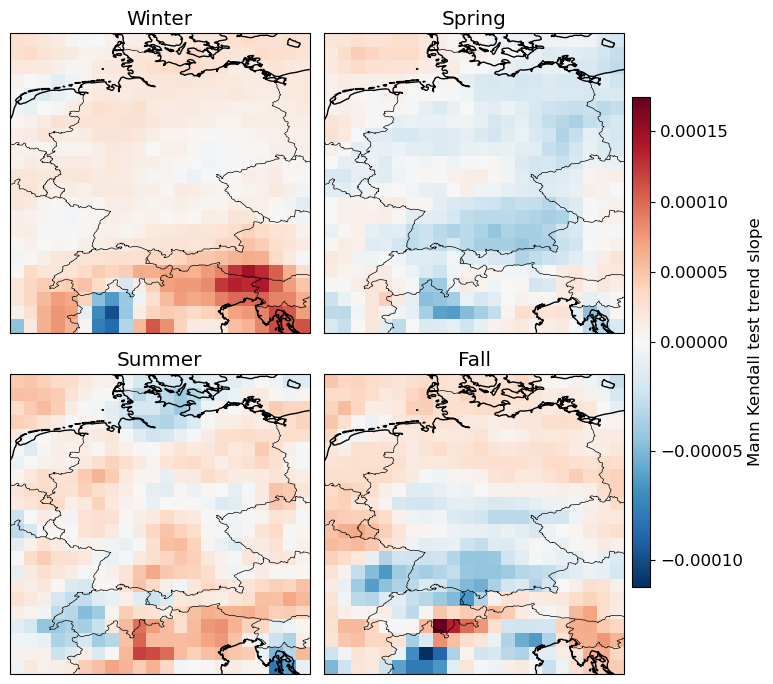

In [25]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(9, 7))
plt.rcParams.update({'font.size': 12})  # Update font size

# Define color map for slope
cmap_slope = plt.cm.RdBu_r
cmap_slope.set_bad(color='gray')
norm_slope = TwoSlopeNorm(vmin=trends_df['slope'].min(), vcenter=0, vmax=trends_df['slope'].max())

# Plot slope data Winter
season_trends_df = trends_df[trends_df['season'] == 'Winter']
season_trends_df.reset_index(inplace=True)
data_array_slope = xr.DataArray(np.reshape(list(season_trends_df['slope']),(len(np.unique(season_trends_df['lon'])), len(np.unique(season_trends_df['lat'])))),
                          coords={'lat': np.unique(season_trends_df['lat']), 'lon': np.unique(season_trends_df['lon'])},
                          dims=['lat', 'lon'])
data_array_slope.plot.imshow(x='lon', y='lat', norm=norm_slope, cmap=cmap_slope, transform=ccrs.PlateCarree(), ax=axs[0,0], add_colorbar=False)
axs[0,0].set_title('Winter')
axs[0,0].set_xlabel('Longitude')
axs[0,0].set_ylabel('Latitude')
axs[0,0].add_feature(cfeature.BORDERS, linewidth=0.5)
axs[0,0].coastlines()

# Plot slope data Spring
season_trends_df = trends_df[trends_df['season'] == 'Spring']
data_array_slope = xr.DataArray(np.reshape(list(season_trends_df['slope']),(len(np.unique(season_trends_df['lon'])), len(np.unique(season_trends_df['lat'])))),
                          coords={'lat': np.unique(season_trends_df['lat']), 'lon': np.unique(season_trends_df['lon'])},
                          dims=['lat', 'lon'])
data_array_slope.plot.imshow(x='lon', y='lat', norm=norm_slope, cmap=cmap_slope, transform=ccrs.PlateCarree(), ax=axs[0,1], add_colorbar=False)
axs[0,1].set_title('Spring')
axs[0,1].set_xlabel('Longitude')
axs[0,1].set_ylabel('Latitude')
axs[0,1].add_feature(cfeature.BORDERS, linewidth=0.5)
axs[0,1].coastlines()

# Plot slope data Summer
season_trends_df = trends_df[trends_df['season'] == 'Summer']
data_array_slope = xr.DataArray(np.reshape(list(season_trends_df['slope']),(len(np.unique(season_trends_df['lon'])), len(np.unique(season_trends_df['lat'])))),
                          coords={'lat': np.unique(season_trends_df['lat']), 'lon': np.unique(season_trends_df['lon'])},
                          dims=['lat', 'lon'])
img = data_array_slope.plot.imshow(x='lon', y='lat', norm=norm_slope, cmap=cmap_slope, transform=ccrs.PlateCarree(), ax=axs[1,0], add_colorbar=False)
axs[1,0].set_title('Summer')
axs[1,0].set_xlabel('Longitude')
axs[1,0].set_ylabel('Latitude')
axs[1,0].add_feature(cfeature.BORDERS, linewidth=0.5)
axs[1,0].coastlines()

# Plot slope data Autumn
season_trends_df = trends_df[trends_df['season'] == 'Fall']
data_array_slope = xr.DataArray(np.reshape(list(season_trends_df['slope']),(len(np.unique(season_trends_df['lon'])), len(np.unique(season_trends_df['lat'])))),
                          coords={'lat': np.unique(season_trends_df['lat']), 'lon': np.unique(season_trends_df['lon'])},
                          dims=['lat', 'lon'])
data_array_slope.plot.imshow(x='lon', y='lat', norm=norm_slope, cmap=cmap_slope, transform=ccrs.PlateCarree(), ax=axs[1,1], add_colorbar=False)
axs[1,1].set_title('Fall')
axs[1,1].set_xlabel('Longitude')
axs[1,1].set_ylabel('Latitude')
axs[1,1].add_feature(cfeature.BORDERS, linewidth=0.5)
axs[1,1].coastlines()

plt.subplots_adjust(wspace=-0.6)  # Adjust the gap between subplots
cax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(img, cax=cax, orientation='vertical', label='Mann Kendall test trend slope')

plt.tight_layout()
plt.savefig('figs/mann_kendall_map_by_season.svg', format='svg', transparent=True)
plt.show()